<a href="https://colab.research.google.com/github/ngockhanh5110/nlp-vietnamese-text-summarization/blob/main/notebooks/inferencing_vietnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install lib**

In [2]:
!pip install vncorenlp datasets==1.0.2
!pip install transformers
!pip install dill==0.3.5.1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.1 MB/s eta 0:00:00
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=258c1cee7366edbc565374b9254823567bf5a70e7ab9fd739dcebf68c9153d03
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install git-python==1.0.3
# !pip install sacrebleu==1.4.12
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=599733c600c1ac08c9b2f783a1d0f2a24df419c927081318edb2c9a9a961539f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [4]:
import os
new_path = "/content/drive/MyDrive/LLM_TEXT/"
os.chdir(new_path)
current_path = os.getcwd()
print("current path:", current_path)

current path: /content/drive/MyDrive/LLM_TEXT


In [5]:
import glob
import pandas as pd
import concurrent.futures
from datasets import *
import datasets
import transformers
import nltk
nltk.download('punkt')

from transformers import RobertaTokenizerFast,AutoTokenizer
from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Processing data**

In [6]:
summary_task_New = []

In [28]:
def listPaths(path):
  pathfiles = list()
  cnt = 0
  for pathfile in glob.glob(path):
    cnt += 1
    pathfiles.append(pathfile)
    if cnt == 20:
       break
  return pathfiles

test_paths = listPaths('/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/*.txt')


In [37]:
def read_content(path_file):
  """
  Input: Path of txt file
  Output
  """

  # print("\n\n path_file:", path_file)
  summary_content = ""
  summary_task = ""
  original = ""
  summary_taskDict = []
  with open(path_file, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      cnt = 0
      # print("\n\n path_file:",path_file)
      # print("\n\n lines:",lines)
      for line in lines:
          line = line.strip()

          if "NOI_DUNG_TOM_TAT" in line:
              cnt = 1
              line = line.replace("NOI_DUNG_TOM_TAT", "")
              line = line.replace(":", "")
          elif "NHIEM_VU" in line:#line.startswith("NHIEM_VU"):
              cnt = 2
              line = line.replace("NHIEM_VU", "")
              line = line.replace(":", "")
          # new code
          elif "NGUOI_LAM" in line: #line.startswith("NGUOI_LAM"):
              summary_taskDict.append({ "people": "", "content": "", "time": ""})
              cnt = 20
              line = line.replace("NGUOI_LAM", "")
              line = line.replace(":", "")
          elif "NOI_DUNG_CV" in line: #line.startswith("NOI_DUNG_CV"):
              cnt = 21
              line = line.replace("NOI_DUNG_CV", "")
              line = line.replace(":", "")
          elif "THOI_GIAN" in line: #line.startswith("THOI_GIAN"):
              cnt = 22
              line = line.replace("THOI_GIAN", "")
              line = line.replace(":", "")
          #end
          elif "NOI_DUNG_GOC" in line: #line.startswith("NOI_DUNG_GOC"):
              cnt = 3
              line = line.replace("NOI_DUNG_GOC", "")
              line = line.replace(":", "")

          line += " "
          # line  = line.replace("..", ". ")
          if line:
            if cnt == 1:
              summary_content += line
            #elif cnt == 2:
            #  summary_task += line
            elif cnt == 20:
              summary_taskDict[-1]["people"] += line
            elif cnt == 21:
              summary_taskDict[-1]["content"] += line
            elif cnt == 22:
              summary_taskDict[-1]["time"] += line

            elif cnt == 3:
              original += line

  # print("summary_content:", summary_content)
  # print("summary_task:", summary_task)
  # print("original:", original)
  summary_task_New.append({'file' : path_file,
          'summary_task': summary_taskDict,})
  return {'file' : path_file,
          # 'summary_task': summary_taskDict,
          'summary_content': summary_content,
          'original': original}

In [38]:
summary_task_New = []
txt = read_content("/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/02.txt")
print("data of txt: ")
print("summary_content: ", txt['summary_content'])
print("original: ", txt['original'])
print("\n")

print("data of txt: ")
for item in summary_task_New:
  # print("item: ", item)
  for task in item['summary_task']:
    # print("task: ", task)
    print("\n")
    print("people: ", task['people'])
    print("content: ", task['content'])
    print("time: ", task['time'])


data of txt: 
summary_content:   ban chi uỷ chi bộ Minh Dương tổ chức cuộc   họp chi uỷ định kỳ tháng 4 năm 2023.  NHIEM_ VU: 
original:   Hôm nay ngày 22 tháng 4 năm 2023, ban chi uỷ chi bộ Minh Dương tổ chức cuộc  họp chi uỷ định kỳ tháng 4 năm 2023. Ông Hoàng Trung Sơn, bí thư chi bộ  là chủ toạ và điều hành cuộc họp và phân công nhiệm vụ cho các thành viên. Các thành viên trong nhóm sẽ được phân công nhiệm vụ cụ thể để đảm nhận trong quá trình hop. Ông Sơn nhận nhiệm vụ đánh giá tình hình thực hiện Nghị quyết tháng 4 đó là chi bộ đã chi bộ thực hiện tốt việc học tập tư tưởng và làm theo tấm gương đạo đức Hồ Chí Minh đề ra một số công việc trong tháng. Deadline 22 tháng 5, 2023. Ông Hải nhận nhiệm vụ kết hợp cùng trưởng thôn phát động phong trào quyên góp quỹ ủng hộ biển đảo vì tổ quốc thân yêu. Deadline 22 tháng 5, 2023. Ông Hùng nhận nhiệm vụ tiếp tục giúp đỡ quần chúng ưu tú Nguyễn Thị thanh Phương để đồng chí Phương được đứng trong hàng ngũ của Đảng. Deadline 17 tháng 5, 2023. V

In [31]:
def get_stop_words_vn(path):
    ret = []
    f = open(path, "r")
    lines = f.readlines()
    for line  in lines:
       line = line.replace("_", " ")
       line = " " + line.replace("\n", "") + " "
       ret.append(line)
    return ret

stop_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt")
task_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-dash.txt")
time_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-time.txt")
# print("stop_words", stop_words)
print("task_words", task_words)

task_words [' nhiệm vụ ', ' đảm nhiệm vai trò ', ' đảm nhận vai trò ', ' đảm nhận công việc ', ' đảm nhiệm nhiệm vụ ', ' được phân công việc ', ' được giao công việc ', ' đã giao cho ', ' phụ trách công việc ', ' sẽ giao công việc ', ' sẽ phân công việc ', ' phân công công việc ', ' sẽ tiến hành ']


**Summary task**

In [12]:
!pip install vncorenlp

In [ ]:
# import os
# from vncorenlp import VnCoreNLP

# # Tải xuống mô hình NER từ GitHub
# os.system('wget https://github.com/vncorenlp/VnCoreNLP/archive/master.zip')
# os.system('unzip master.zip')

# # Lưu trữ đường dẫn đến thư mục chứa mô hình NER
# vncorenlp_folder = 'VnCoreNLP-master'
# vncorenlp_file = os.path.join(vncorenlp_folder, 'VnCoreNLP-1.1.1.jar')

In [13]:
import os
from vncorenlp import VnCoreNLP
vncorenlp_folder = '/content/drive/MyDrive/LLM_TEXT/VnCoreNLP-master/'
vncorenlp_file = os.path.join(vncorenlp_folder, 'VnCoreNLP-1.1.1.jar')

vnlp = VnCoreNLP(vncorenlp_file, annotators="wseg,pos,ner")

In [15]:
text = "Hôm nay ngày 21 tháng 4 năm 2023 tại trường THCS kim Liên diễn ra cuộcHôm nay, Mai Anh và hải đăng đã đến thăm chị Lan tại Hà Nội. họp của ban trung tâm bàn nội "
def getName(str):
  annotated_text = vnlp.annotate(str)
  # print ("annotated_text",annotated_text)

  person_entities = []
  for sentence in annotated_text['sentences']:
      # print (sentence)
      for entity in sentence:
          if entity["nerLabel"] == 'B-PER':
              person_entities.append(entity["form"])
  return person_entities

print(getName(text))

['Mai_Anh', 'Lan']


In [49]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')
import re

def contains_digits(input_str):
    # Biểu thức chính quy để kiểm tra xem chuỗi có chứa số từ 0 đến 9 hay không
    digit_pattern = r'\d'

    # Tìm kiếm bất kỳ số từ 0 đến 9 nào trong chuỗi đầu vào
    match = re.search(digit_pattern, input_str)

    return match is not None

def process_content_sentences( body: str, min_length=5, max_length=50):
        # for word in reversed(stop_words):
        #   body.replace(word, " ")
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

def detectTask(str):
  sentences = process_content_sentences(str, 1, 400)
  ret = []
  for sentence in sentences:

    sentencelower = sentence.lower()
    time = ""
    for wTime in time_words:
      if wTime.strip() in sentencelower:
          time = sentencelower
          try:
            if contains_digits(time):
              ret[-1]["time"] = time
              # print("time ", time)
          except:
            pass

          break
    for wTask in task_words:
      if wTask.strip() in sentencelower:

        # for word in reversed(stop_words):
        #   sentence = sentence.replace(word, " ")
        # print(sentence)
        people = getName(sentence)
        ret.append({"people": people, "content": sentencelower, "time": "" })
        break
  return ret

In [18]:
txt = read_content("/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/11.txt")
print ("txt['original']", txt['original'])
test_task = detectTask(txt['original'])
for task in test_task:
  print ("task", task)

txt['original']  Hôm nay vào hồi 16 giờ ngày 22 tháng 8 năm 2021  diễn ra cuộc họp của  ban chấp hành công đoàn trường TH Minh Khai định kỳ  nhằm đánh giá hoạt động của UBKT tháng 8 năm 2021 và triển khai kế hoạch hoạt động của UBKT tháng 9 năm 2021. BCH công đoàn gồm 4 thành viên : Lan, Hương, Mạnh. Kiên. Lan chủ tịch công đoàn là chủ tọa  điều hành cuộc họp và phân công nhiệm vụ cụ thể  cho các thành viên. Lan đảm nhận đánh giá trong tháng 8 của ban BCH công đoàn và triển khai nhiệm vụ tháng 9 của UBKT. Deadline 22 tháng 8, 2021. Hương đảm nhận  kiểm tra, giám sát việc thực hiện điều lệ, kế hoạch, nghị quyết của CĐCS. Deadline 22 tháng 9, 2021. Mạnh đảm nhận xây dựng kế hoạch cho ngày kỉ niệm 76 Quốc khánh nước cộng hoà xã hội chủ nghĩa Việt Nam. Deadline 2 tháng 9, 2021. Kiên  đảm nhận kết hợp với các đồng chí Lan, và Hương thực hiện tốt nhiệm vụ được phân công. Deadline 20 tháng 9, 2021. Thời gian để cả tổ hoàn thành các nhiệm vụ bắt đầu từ hôm nay, ngày 22 tháng 8 năm 2021 đến ngà

In [19]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)

  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [42]:
summary_task_New = []
test_df = get_dataframe(test_paths)
print ("test_df", test_df["summary_content"] )



test_df 0      Trong cuộc họp giao nhiệm vụ của công ty Vạn ...
1      Ban chi uỷ chi bộ Minh Dương tổ chức cuộc   h...
2     ﻿ Lớp 11A3 tổ chức cuộc họp năm khen thưởng độ...
3     ﻿ Trong cuộc họp giao nhiệm vụ của công ty Mai...
4      Tổ chuyên môn số 5 trường tiểu học Kim Liên s...
5     ﻿ Trường THCS Lê Lợi diễn ra cuộc họp chuyên m...
6     ﻿ Ban chi uỷ chi bộ bệnh viện đa khoa Đan Phượ...
7      Trường THCS kim Liên diễn ra cuộc họp của ban...
8      Tại trường trường THCS Nguyễn Huệ  diễn ra cu...
9     ﻿ Vào hồi 15 giờ 30  ngày 23 tháng 02 năm 2023...
10     Vào 7 giờ 15 phút ngày 24 tháng 6 năm 2023 , ...
11    ﻿ Cuộc họp quan trọng để bàn về dự án thiết kế...
12     Ban chỉ đạo trường THCS Hồng Thái họp bàn về ...
13    ﻿ Ngày 10 tháng 9 năm 2022, ban giám đốc Công ...
14     Công ty Nam Khánh  diễn ra cuộc họp quan trọn...
15     Gia đình Tuyến tổ chức cuộc họp nhằm tìm các ...
16    ﻿ Cuộc họp diễn ra tại công ty Vạn Thắng nhằm ...
17     Gia đình ông Nguyễn Văn Tùng tổ c

In [21]:
test_data =  Dataset.from_pandas(test_df)

In [22]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

# **Inference**

In [23]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/training/checkpoint-30000')
model.to("cpu")
batch_size = 32  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["original"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu")
    attention_mask = inputs.attention_mask.to("cpu")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [25]:

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["original"])

result_summary_content = results["pred"]
summary_content_original = results["summary_content"]
# summary_task_original = results["summary_task"]


print ("result_summary_content: ",result_summary_content[0] )
print ("file: ",test_data[0]["file"]  )
print ("summary_conten: ",summary_content_original[0] )
# print ("summary_task: ",summary_task_original[0] )
print ("original: ",test_data[0]["original"] )

  0%|          | 0/1 [00:00<?, ?ba/s]

result_summary_content:  DeadDeadline nhận_định, Deadline sẽ là 2 trong số những đồng_nghiệp tốt nhất mà các đồng_nghiệp trong nghề của mình cần tránh xa.
file:  /content/drive/MyDrive/LLM_TEXT/dataset/BBCH/16.txt
summary_conten:  ﻿ Vào hồi 15 giờ 30  ngày 23 tháng 02 năm 2023, BCH chi đoàn trường TH Vân Canh tổ chức cuộc họp. với nội dung:  Đánh giá công tác tháng 02 và triển khai công tác tháng 03  
original:   Hôm  nay vào hồi 15 giờ 30  ngày 23 tháng 02 năm 2023, BCH chi đoàn trường TH Vân Canh tổ chức cuộc họp. với nội dung:  Đánh giá công tác tháng 02 và triển khai công tác tháng 03. Cuộc họp có 4 đoàn viên tham gia đó là các đồng chí:  Hằng, Thu, Huệ, Tùng. Hằng sẽ đảm nhận thông qua các nội dung và giao  nhiệm vụ của  BCH cho từng thành viên. Deadline 23 tháng 2, 2023.Tú sẽ  triển khai kế hoạch hoạt động của đoàn xã đến từng đoàn viên trong chi đoàn.Deadline 28 tháng 2, 2023. Thu đảm nhận phát động  phong trào hiến máu tình nguyện tới các đoàn viên, lập danh sách gửi đoàn xã. D

In [50]:
result_summary_task = []
for data in test_df["original"]:
  ret_task = detectTask(data)
  result_summary_task.append(ret_task)
  for task in ret_task:
    print ("task", task)

task {'people': [], 'content': 'trong cuộc họp giao nhiệm vụ của chúng ta, chúng ta đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong nhóm.', 'time': ''}
task {'people': ['Phương'], 'content': 'dưới đây là phân công cụ thể và deadline cho mỗi thành viên: phương sẽ đảm nhận vai trò chính trong việc thiết kế giao diện người dùng (ui) và trang chủ.', 'time': ''}
task {'people': ['Phương'], 'content': 'nhiệm vụ của phương sẽ là thiết kế giao diện người dùng cho trang web quản lý nhân sự, bao gồm trang chủ hiển thị thông tin tổng quan và các thành phần ui cần thiết.', 'time': 'deadline 1 tháng 1, 2023.'}
task {'people': [], 'content': 'anh sẽ được giao các nhiệm vụ sau: xây dựng chức năng quản lý nhân viên.', 'time': ''}
task {'people': [], 'content': 'nhiệm vụ: phát triển chức năng quản lý nhân viên, bao gồm thêm, xóa, sửa thông tin nhân viên, tìm kiếm và sắp xếp danh sách nhân viên.', 'time': 'deadline 7 tháng 1, 2023.'}
task {'people': ['Linh'], 'co

### **Evaluation**


In [52]:
print("Evaluation content")
rouge_summary_content = rouge.compute(predictions=result_summary_content, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_summary_content.items():
  print(key)
  print(value.mid)

Evaluation content
rouge1
Score(precision=0.5930926617899651, recall=0.41240481102517956, fmeasure=0.4556215687413313)
rouge2
Score(precision=0.16947298595175792, recall=0.11504755909490968, fmeasure=0.12864041873140947)
rougeL
Score(precision=0.3569271562222126, recall=0.25057055295528513, fmeasure=0.27407956775439374)


In [53]:
print("Evaluation task")
rouge_summary_task = rouge.compute(predictions=result_summary_task, references=summary_task_original, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_summary_task.items():
  print(key)
  print(value.mid)

Evaluation task


NameError: ignored

# **Draw a comparison chart**

In [ ]:
models = ['Summary content', 'Summary task']
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []

rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []

rougel_recall = []
rougel_precision = []
rougel_f1 = []

def getRougeMyModel(rouge_output):
   for key,value in rouge_output.items():
      if key == "rouge1":
         rouge1_recall.append(value.mid[0])
         rouge1_precision.append(value.mid[1])
         rouge1_f1.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall.append(value.mid[0])
         rouge2_precision.append(value.mid[1])
         rouge2_f1.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[1])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[1])

print("Evaluation content")
getRougeMyModel(rouge_summary_content)
print("Evaluation task")
getRougeMyModel(rouge_summary_task)

Evaluation content
rouge1:recall 0.5034507122975899 -precision 0.5310964481758056 -F1-Score 0.5034904064877377
rouge2:recall 0.16363053775662556 -precision 0.16154057784492568 -F1-Score 0.16154057784492568
rougeL:recall 0.30957902934179127 -precision 0.3218988837076229 -F1-Score 0.3218988837076229
Evaluation task
rouge1:recall 0.9245158412613395 -precision 0.538393463003313 -F1-Score 0.657857087965732
rouge2:recall 0.6170574105892872 -precision 0.3554467795610713 -F1-Score 0.3554467795610713
rougeL:recall 0.6580806259903251 -precision 0.38956136143252695 -F1-Score 0.38956136143252695


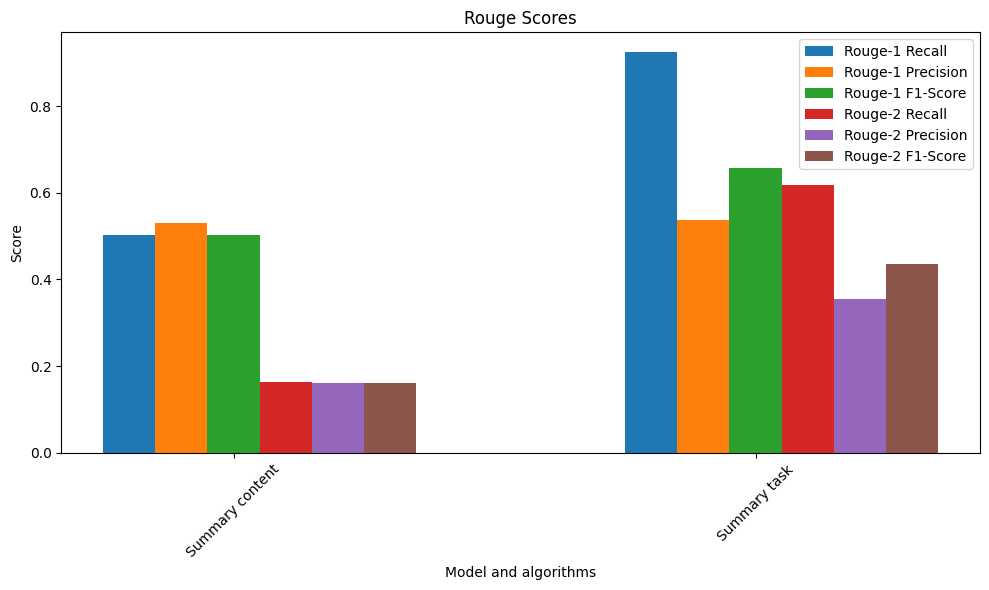

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(len(models))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1, width, label='Rouge-2 F1-Score')
plt.xlabel('Model and algorithms')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()